In [1]:
import tensorboard

In [2]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tqdm
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import src.data.Dataset as dt

In [3]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [4]:
version = "v1.1"

img_weight = 224
img_height = 224

batch_size = 32

seed = 42

epochs = 50


In [5]:
datagen_train = ImageDataGenerator(rescale=1.0 / 255)

# mobilenetV2 = MobileNetV2(
#     include_top=False, input_shape=(img_weight, img_height, 3), weights="imagenet"
# )

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetV2 = hub.KerasLayer(url, input_shape=(img_weight, img_height, 3))

mobilenetV2.trainable = False

model = Sequential(
    [
        mobilenetV2,
        Dense(1, activation="sigmoid", name="Output_Layer"),
    ],
    name=f"MobileNetV2_{version}",
)

model.summary()

Model: "MobileNetV2_v1.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 Output_Layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint(
    f"./models/MobileNetV2//best_MobileNetV2_{version}.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1,
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    mode="min",
    verbose=1,
    restore_best_weights=True,
)

tensorBoard = TensorBoard(log_dir=f"./logs/MobileNetV2/{version}")

In [7]:
DATASET_PATH = os.path.abspath("./dataset/datasetFiltered")

TRAIN_CSV = os.path.abspath("./data/processed/train/29618Train.csv")
VALIDATION_CSV = os.path.abspath("./data/processed/validation/29618Validation.csv")
TEST_CSV = os.path.abspath("./data/processed/test/29618Test.csv")

print(f"DATASET_PATH:   {DATASET_PATH}")
print(f"TRAIN_CSV:      {TRAIN_CSV}")
print(f"VALIDATION_CSV: {VALIDATION_CSV}")
print(f"TEST_CSV:       {TEST_CSV}")


DATASET_PATH:   /Users/carlos/WORKSPACE/MegaClassifier/dataset/datasetFiltered
TRAIN_CSV:      /Users/carlos/WORKSPACE/MegaClassifier/data/processed/train/29618Train.csv
VALIDATION_CSV: /Users/carlos/WORKSPACE/MegaClassifier/data/processed/validation/29618Validation.csv
TEST_CSV:       /Users/carlos/WORKSPACE/MegaClassifier/data/processed/test/29618Test.csv


In [8]:
train_csv = dt.load_from_csv(TRAIN_CSV)
vali_csv = dt.load_from_csv(VALIDATION_CSV)
test_csv = dt.load_from_csv(TEST_CSV)

The file /Users/carlos/WORKSPACE/MegaClassifier/data/processed/train/29618Train.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/processed/validation/29618Validation.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/processed/test/29618Test.csv has been successfully opened.


In [9]:
columns = ["file_name", "label"]

data = []
for _, row in train_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row["file_name"])
    label = row["label"]
    data.append([file_name, label])
train_dataset = pd.DataFrame(data, columns=columns)
train_dataset["label"] = train_dataset["label"].astype(str)

data = []
for _, row in vali_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row["file_name"])
    label = row["label"]
    data.append([file_name, label])
vali_dataset = pd.DataFrame(data, columns=columns)
vali_dataset["label"] = vali_dataset["label"].astype(str)

data = []
for _, row in test_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row["file_name"])
    label = row["label"]
    data.append([file_name, label])
test_dataset = pd.DataFrame(data, columns=columns)
test_dataset["label"] = test_dataset["label"].astype(str)

In [10]:
datagen_val_test = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=seed,
)

val_generator = datagen_val_test.flow_from_dataframe(
    dataframe=vali_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=seed,
)

test_generator = datagen_val_test.flow_from_dataframe(
    dataframe=test_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
)

Found 20732 validated image filenames belonging to 2 classes.
Found 4442 validated image filenames belonging to 2 classes.
Found 4444 validated image filenames belonging to 2 classes.


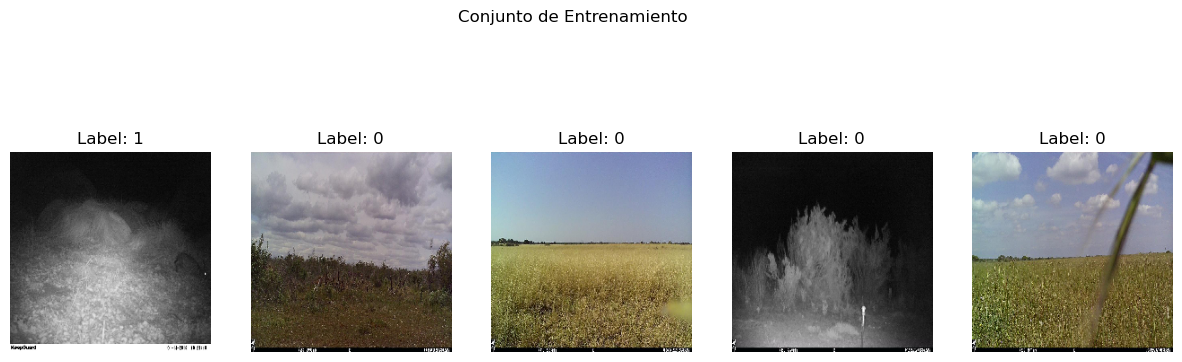

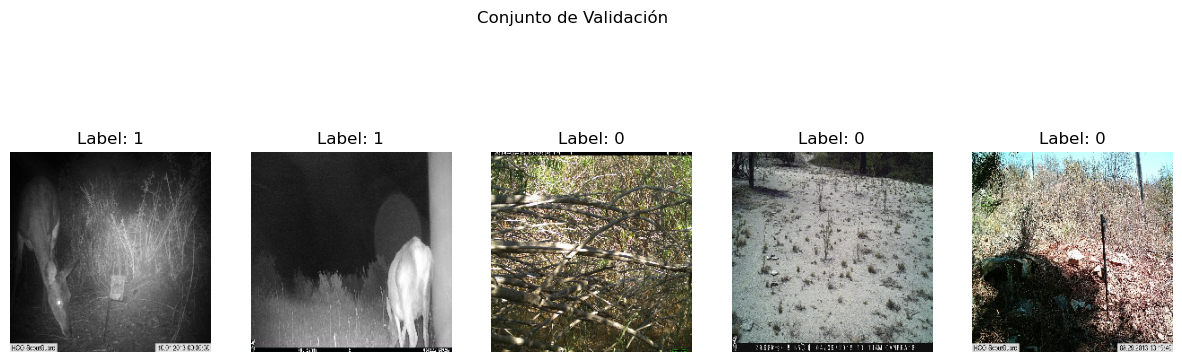

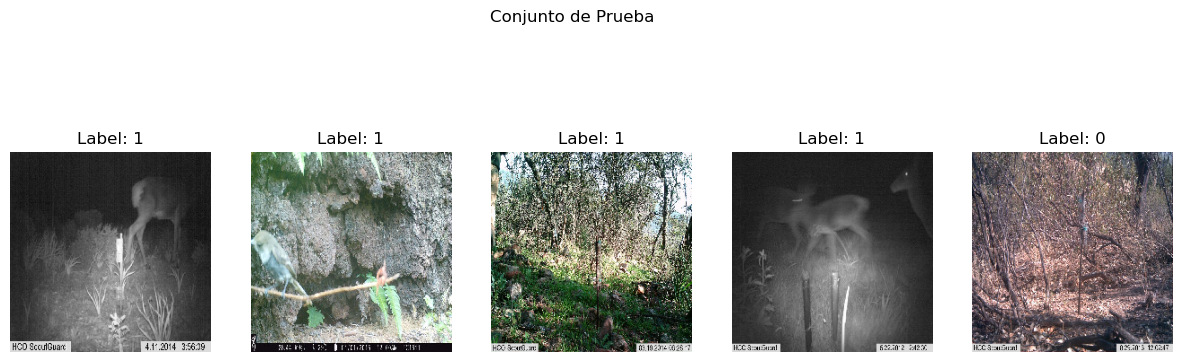

In [11]:
def show_random_images_from_generator(generator, title):
    images, labels = next(
        generator
    )  # Toma un batch de imágenes y etiquetas del generador
    plt.figure(figsize=(15, 5))
    for i in range(5):  # Muestra 5 imágenes del batch
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_random_images_from_generator(train_generator, "Conjunto de Entrenamiento")
show_random_images_from_generator(val_generator, "Conjunto de Validación")
show_random_images_from_generator(test_generator, "Conjunto de Prueba")

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=2000 // batch_size,
    callbacks=[checkpoint, early_stop, tensorBoard],
)
model.save(f"./models/MobileNetV2/MobileNetV2_{version}.h5")

Epoch 1/50


2024-11-03 12:05:01.502088: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


62/62 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.7566
Epoch 1: val_loss improved from inf to 0.36594, saving model to ./models/MobileNetV2/best_MobileNetV2_v1.1.h5
62/62 [==============================] - 40s 628ms/step - loss: 0.4806 - accuracy: 0.7566 - val_loss: 0.3659 - val_accuracy: 0.8388
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8352
Epoch 2: val_loss improved from 0.36594 to 0.32466, saving model to ./models/MobileNetV2/best_MobileNetV2_v1.1.h5
62/62 [==============================] - 38s 623ms/step - loss: 0.3480 - accuracy: 0.8352 - val_loss: 0.3247 - val_accuracy: 0.8604
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.8589
Epoch 3: val_loss improved from 0.32466 to 0.30232, saving model to ./models/MobileNetV2/best_MobileNetV2_v1.1.h5
62/62 [==============================] - 37s 604ms/step - loss: 0.3220 - accuracy: 0.8589 - val_loss: 0.3023 - val_accuracy: 0.

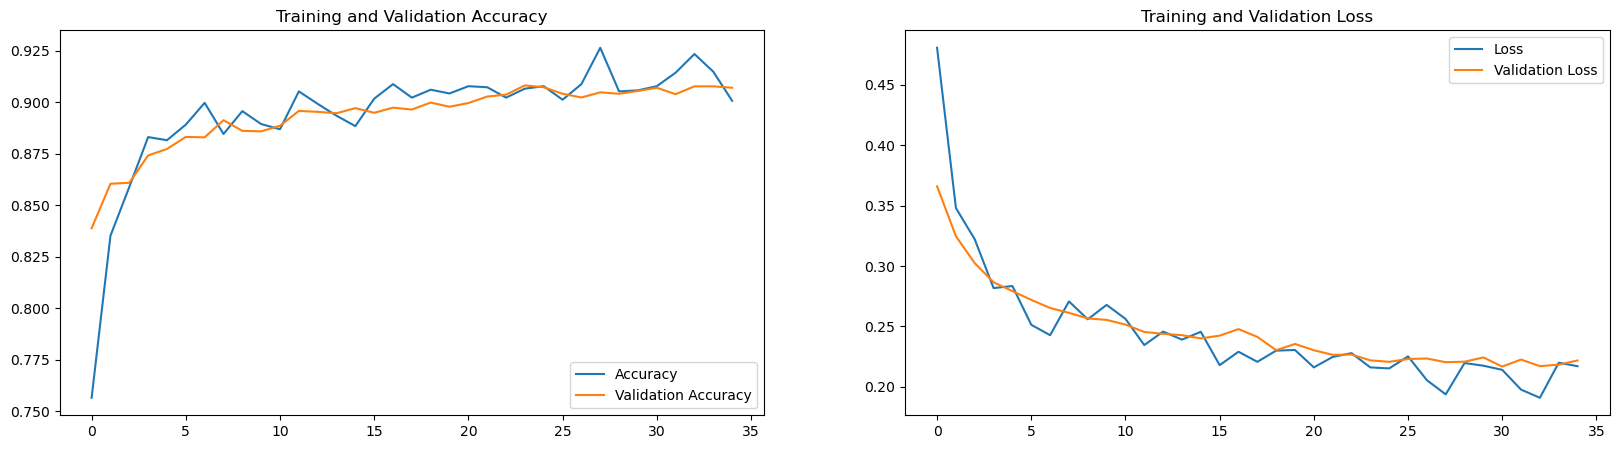

In [13]:
def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()


plot_training_history(history)

In [14]:
from tensorflow import keras

mobilenetv2 = keras.models.load_model(
    f"./models/MobileNetV2/MobileNetV2_{version}.h5",
    custom_objects={"KerasLayer": hub.KerasLayer},
)
evaluate = mobilenetv2.evaluate(test_generator)


139/139 [==============================] - 26s 183ms/step - loss: 0.2260 - accuracy: 0.9030


In [15]:
test_labels = test_generator.classes

predict = mobilenetv2.predict(test_generator)
predict_flatten = predict.flatten()

Random Classifier: ROC AUC=0.5
MobileNetV2 v1.1: ROC AUC=0.9654


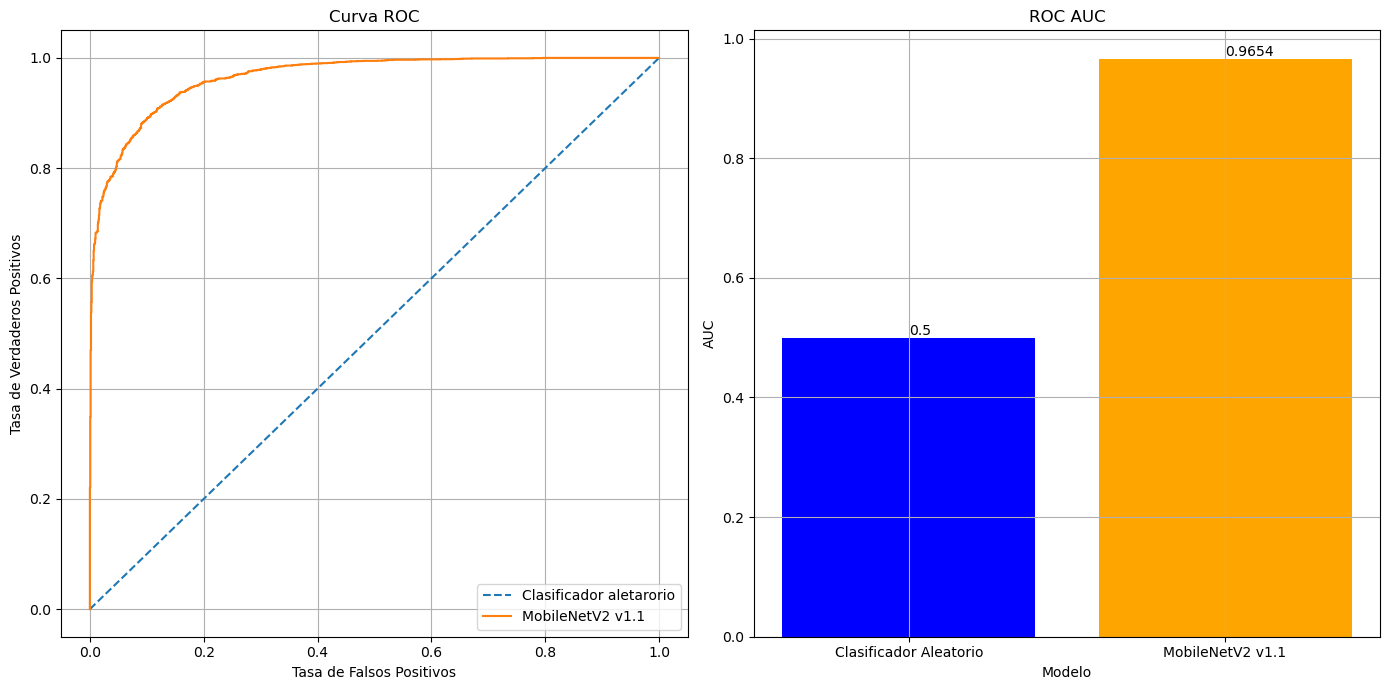

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Generar predicciones aleatorias
random_flatten = np.zeros_like(test_labels)

# Calcular el AUC
random_auc = roc_auc_score(test_labels, random_flatten)
mobilenetv2_auc = roc_auc_score(test_labels, predict_flatten)

print("Random Classifier: ROC AUC=%.1f" % (random_auc))
print(f"MobileNetV2 {version}: ROC AUC=%.4f" % (mobilenetv2_auc))

# Calcular la curva ROC
random_false_positive_rate, random_true_positive_rate, _ = roc_curve(
    test_labels, random_flatten
)
mobilenetv2_false_positive_rate, mobilenetv2_true_positive_rate, _ = roc_curve(
    test_labels, predict_flatten
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot ROC curve
ax1.plot(
    random_false_positive_rate,
    random_true_positive_rate,
    linestyle="--",
    label="Clasificador aletarorio",
)
ax1.plot(
    mobilenetv2_false_positive_rate,
    mobilenetv2_true_positive_rate,
    # marker=".",
    label=f"MobileNetV2 {version}",
)
ax1.set_title("Curva ROC")
ax1.set_xlabel("Tasa de Falsos Positivos")
ax1.set_ylabel("Tasa de Verdaderos Positivos")
ax1.legend()
ax1.grid(True)

# Plot AUC values
auc_labels = ["Clasificador Aleatorio", f"MobileNetV2 {version}"]
auc_values = [random_auc, mobilenetv2_auc]
bars = ax2.bar(auc_labels, auc_values, color=["blue", "orange"])
ax2.set_title("ROC AUC")
ax2.set_xlabel("Modelo")
ax2.set_ylabel("AUC")
ax2.grid(True)

for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), va="bottom")

plt.tight_layout()
plt.show()


Predicción: 0.9998, Clase predicha: [1]
Predicción: 0.8660, Clase predicha: [1]
Predicción: 0.1893, Clase predicha: [0]
Predicción: 0.9996, Clase predicha: [1]
Predicción: 0.2216, Clase predicha: [0]
Predicción: 0.9982, Clase predicha: [1]
Predicción: 0.9779, Clase predicha: [1]
Predicción: 0.9981, Clase predicha: [1]
Predicción: 0.1620, Clase predicha: [0]
Predicción: 0.9870, Clase predicha: [1]


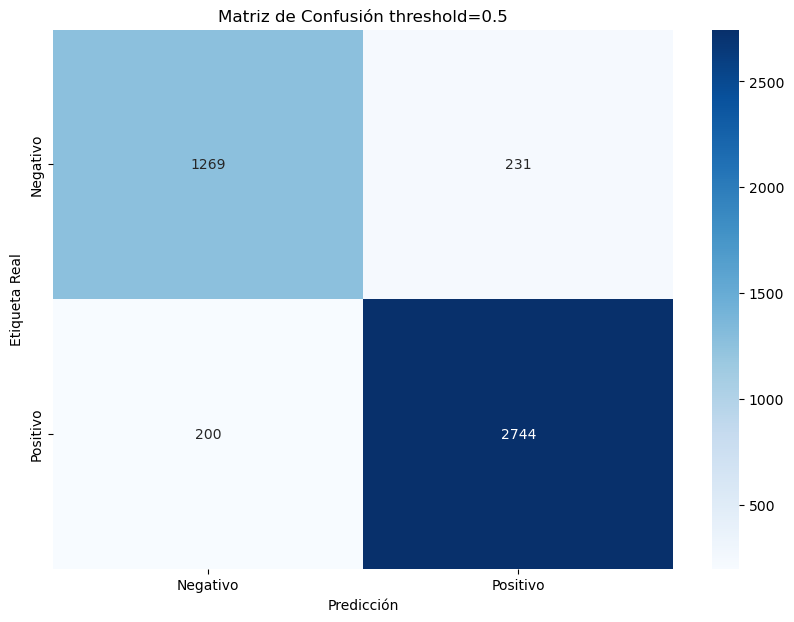

In [17]:
from scipy.special import expit

threshold = 0.5

# Convertir las predicciones a clases binarias usando la función sigmoide
# predicted_classes = (expit(predict_flatten) >= threshold).astype(int)
predicted_classes = (predict > threshold).astype(int)

# Mostrar las primeras 10 predicciones y sus clases correspondientes
for i in range(10):
    print(
        f"Predicción: {predict_flatten[i]:.4f}, Clase predicha: {predicted_classes[i]}"
    )

# Crear la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)

# Dibujar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negativo", "Positivo"],
    yticklabels=["Negativo", "Positivo"],
)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title(f"Matriz de Confusión threshold={threshold}")
plt.show()

In [18]:
loss, accuracy = evaluate

df_results = pd.DataFrame(
    {
        "False Positive Rate": mobilenetv2_false_positive_rate,
        "True Positive Rate": mobilenetv2_true_positive_rate,
        "AUC": [mobilenetv2_auc] * len(mobilenetv2_false_positive_rate),
        "Loss": [loss] * len(mobilenetv2_false_positive_rate),
        "Accuracy": [accuracy] * len(mobilenetv2_false_positive_rate),
    }
)

path = f"./logs/MobileNetV2/{version}/test"
file_path = path + "/events.out.tfevents.csv"

os.makedirs(path, exist_ok=True)
df_results.to_csv(file_path, index=False)